# Castile and Leon: Crops

### Description:
TODO

### Author:
Sergio García Prado ([garciparedes.me](https://garciparedes.me))

In [1]:
rm(list = ls())

In [2]:
library(readr)
library(ggplot2)
library(dplyr)
library(tidyr)
library(RSocrata)
library(ca)
library(forcats)
library(reshape2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



## Data Adquisition:

In [3]:
my.read.csv <- function(url, filename) {
    if (!file.exists(filename)) {
        write_csv(read.socrata(url), filename)
    }
    return(read_csv(filename))
}

In [4]:
crops.herbaceous <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/agu2-cspz.csv",
                               "./data/crops-herbaceous.csv")

Parsed with column specification:
cols(
  a_o = col_integer(),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  ocupaci_n_primera_regad_o = col_integer(),
  ocupaci_n_primera_secano = col_integer(),
  ocupaciones_asociadas_regad_o = col_character(),
  ocupaciones_asociadas_secano = col_character(),
  ocupaciones_posteriores_regad_o = col_character(),
  ocupaciones_posteriores_secano = col_character()
)


In [5]:
crops.woody <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/2vwa-si9n.csv",
                           "./data/crops-woody.csv")

Parsed with column specification:
cols(
  a_o = col_datetime(format = ""),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  n_total_arboles_diseminados = col_integer(),
  superficie_regad_o_en_producci_n = col_integer(),
  superficie_regad_o_que_no_pruduce = col_integer(),
  superficie_secano_en_producci_n = col_integer(),
  superficie_secano_que_no_pruduce = col_integer()
)


## Data Exploration:

In [6]:
colnames(crops.herbaceous)

[1] "a_o"                             "codigo_comarca"                 
 [3] "codigo_muncipio"                 "codigo_producto"                
 [5] "codigo_provincia"                "comarca"                        
 [7] "cultivo"                         "grupo_de_cultivo"               
 [9] "municipio"                       "ocupaci_n_primera_regad_o"      
[11] "ocupaci_n_primera_secano"        "ocupaciones_asociadas_regad_o"  
[13] "ocupaciones_asociadas_secano"    "ocupaciones_posteriores_regad_o"
[15] "ocupaciones_posteriores_secano"

#### Remove Unnecesary Columns and Rename Interesting Columns

In [7]:
code.province.to.province <- function(code) {
    return(switch(as.character(code),
           "47" = "Valladolid",
           "24" = "León",
           "34" = "Palencia",
           "37" = "Salamanca",
           "9"  = "Burgos",
           "49" = "Zamora",
           "5"  = "Ávila",
           "42" = "Soria",
           "40" = "Segovia"))
}

In [8]:
crops.herbaceous.use <- crops.herbaceous %>%
    select(a_o, codigo_provincia:ocupaci_n_primera_secano) %>%
    rename(year = a_o, 
           code.province = codigo_provincia, 
           region = comarca, 
           crop = cultivo, 
           crop.group = grupo_de_cultivo, 
           town = municipio, 
           area.irrigation = ocupaci_n_primera_regad_o, 
           area.dry = ocupaci_n_primera_secano) %>%
    rowwise() %>%
    mutate(province = sapply(code.province,code.province.to.province),
           area.total = sum(area.dry,area.irrigation, na.rm=TRUE)) %>%
    ungroup() %>%
    select(-code.province)

#### View Data Sample

In [9]:
sample_n(crops.herbaceous.use, 10)

year,region,crop,crop.group,town,area.irrigation,area.dry,province,area.total
2016,BENAVENTE Y LOS VALLES,TRIGO BLANDO,CEREALES GRANO,VILLANUEVA DE AZOAGUE,47,144,Zamora,191
2015,BOEDO-OJEDA,ESPARCETA,CULTIVOS FORRAJEROS,SOTOBAÑADO Y PRIORATO,NA,1,Palencia,1
2013,VALLE DEL TIETAR,TOMATE,HORTALIZAS,ADRADA (LA),1,NA,Ávila,1
2015,SAYAGO,ALGARROBA,LEGUMINOSAS GRANO,PEÑAUSENDE,NA,28,Zamora,28
2014,BUREBA-EBRO,VEZA PARA FORRAJE,CULTIVOS FORRAJEROS,REINOSO,0,7,Burgos,7
2015,AVILA,TRIGO,CEREALES GRANO,MIRONCILLO,NA,100,Ávila,100
2011,CUELLAR,MAIZ FORRAJERO,CULTIVOS FORRAJEROS,MARTIN MUÑOZ DE LAS POSADAS,9,NA,Segovia,9
2014,CENTRO,GIRASOL,CULTIV. INDUSTRIALES,CASTRILLO-TEJERIEGO,3,75,Valladolid,78
2016,CUELLAR,PATATA TARDIA,TUBERCULOS,SANTIUSTE DE SAN JUAN BAUTISTA,27,NA,Segovia,27
2011,BUREBA-EBRO,TRIGO,CEREALES GRANO,MIRAVECHE,NA,737,Burgos,737


In [10]:
summary(crops.herbaceous.use)

      year         region              crop            crop.group       
 Min.   :2010   Length:157965      Length:157965      Length:157965     
 1st Qu.:2011   Class :character   Class :character   Class :character  
 Median :2013   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2013                                                           
 3rd Qu.:2015                                                           
 Max.   :2016                                                           
                                                                        
     town           area.irrigation      area.dry         province        
 Length:157965      Min.   :   0.00   Min.   :    0.0   Length:157965     
 Class :character   1st Qu.:   0.00   1st Qu.:    3.0   Class :character  
 Mode  :character   Median :   3.00   Median :   18.0   Mode  :character  
                    Mean   :  29.76   Mean   :  119.9                     
                    3rd Qu.:  19.00   3rd

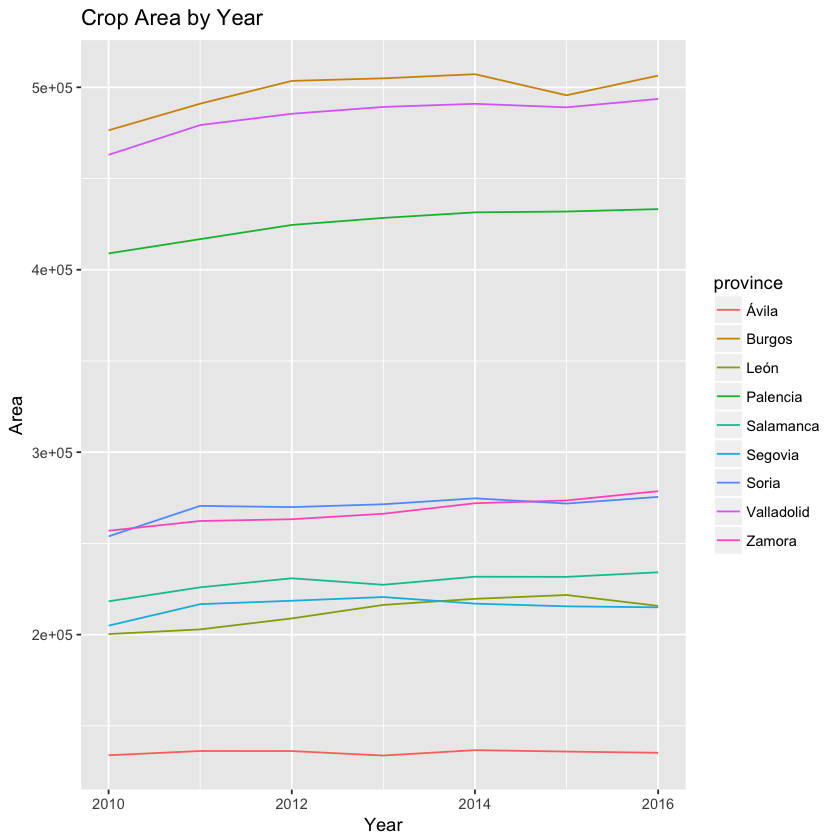

In [11]:
crops.herbaceous.use %>%
    select(year, area.total, province) %>%
    group_by(year, province) %>%
    summarise(area.total = sum(area.total, na.rm = TRUE)) %>%
    ggplot(aes(x=year, y = area.total, 
               group = province,
               col = province)) +
        labs(title = "Crop Area by Year", 
             x = "Year", y = "Area") + 
        geom_line()

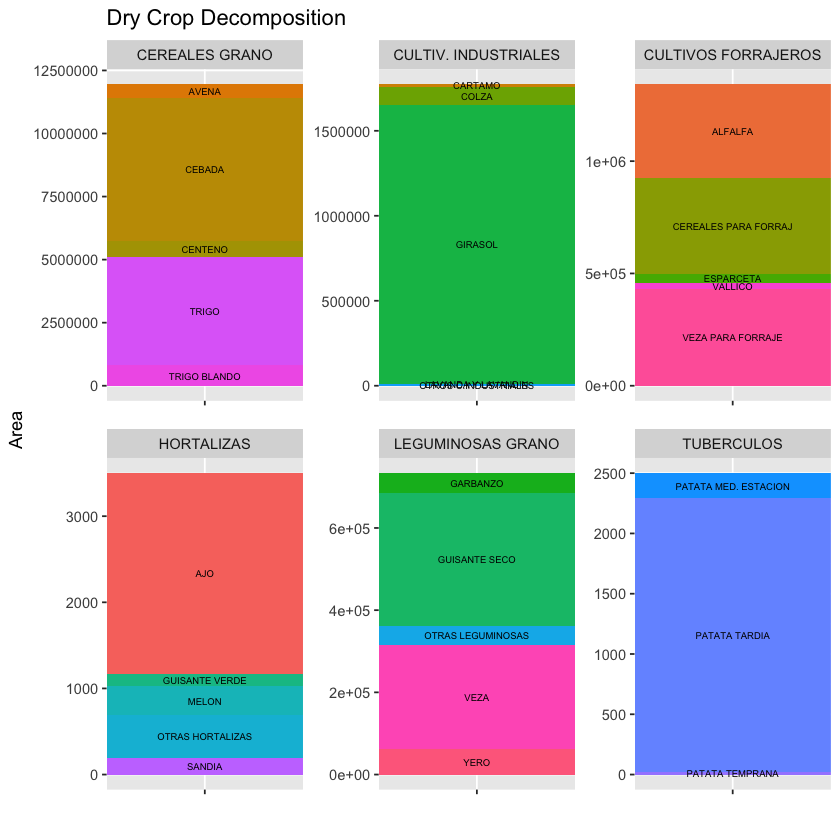

In [12]:
crops.herbaceous.use %>%
    select(crop, crop.group, area.dry) %>%
    filter(area.dry > 0) %>%
    group_by(crop.group, crop) %>%
    summarise(ocupacion = sum(area.dry, na.rm = TRUE)) %>%
    top_n(5, ocupacion) %>%
    ggplot(aes(x = "", y = ocupacion, fill = crop, label = crop)) + 
        geom_bar(width = 1, stat="identity") +
        guides(fill=guide_legend(ncol=2)) +
        theme(legend.position='none') + 
        labs(title = "Dry Crop Decomposition", 
             x = "", y = "Area") + 
        facet_wrap( ~ crop.group, scales = "free")+ 
        geom_text(size = 2, position = position_stack(vjust = 0.5)) 

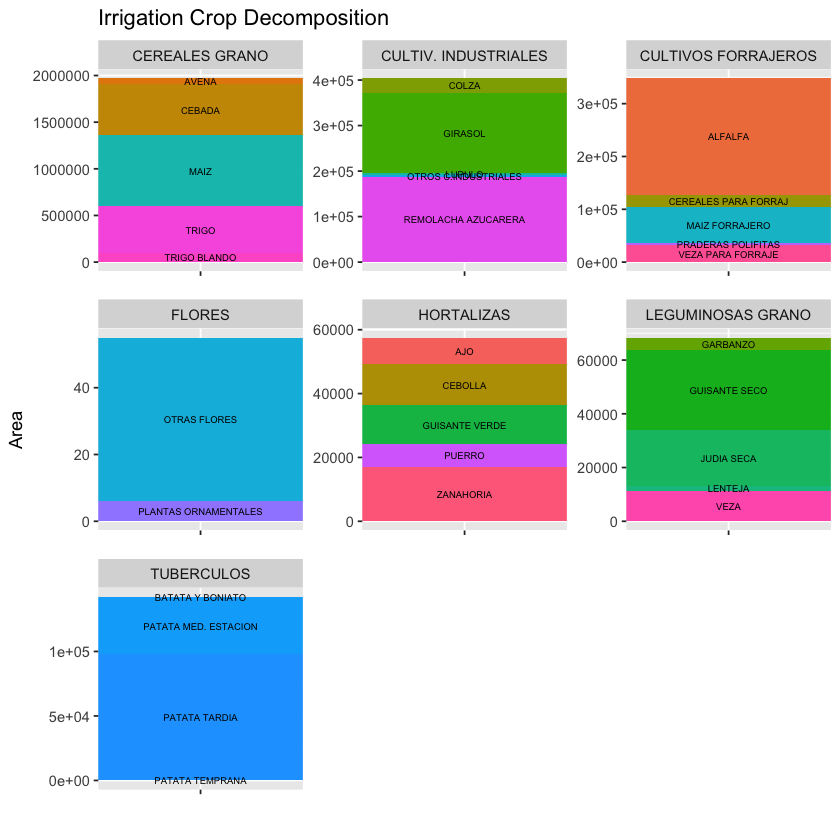

In [13]:
crops.herbaceous.use %>%
    select(crop, crop.group, area.irrigation) %>%
    filter(area.irrigation > 0) %>%
    group_by(crop.group, crop) %>%
    summarise(ocupacion = sum(area.irrigation, na.rm = TRUE)) %>%
    top_n(5, ocupacion) %>%
    ggplot(aes(x = "", y = ocupacion, fill = crop, label = crop)) + 
        geom_bar(width = 1 , stat="identity") +
        guides(fill=guide_legend(ncol=2)) +
        theme(legend.position='none') + 
        labs(title = "Irrigation Crop Decomposition", 
             x = "", y = "Area") +
        facet_wrap( ~ crop.group, scales = "free")+ 
        geom_text(size = 2, position = position_stack(vjust = 0.5)) 

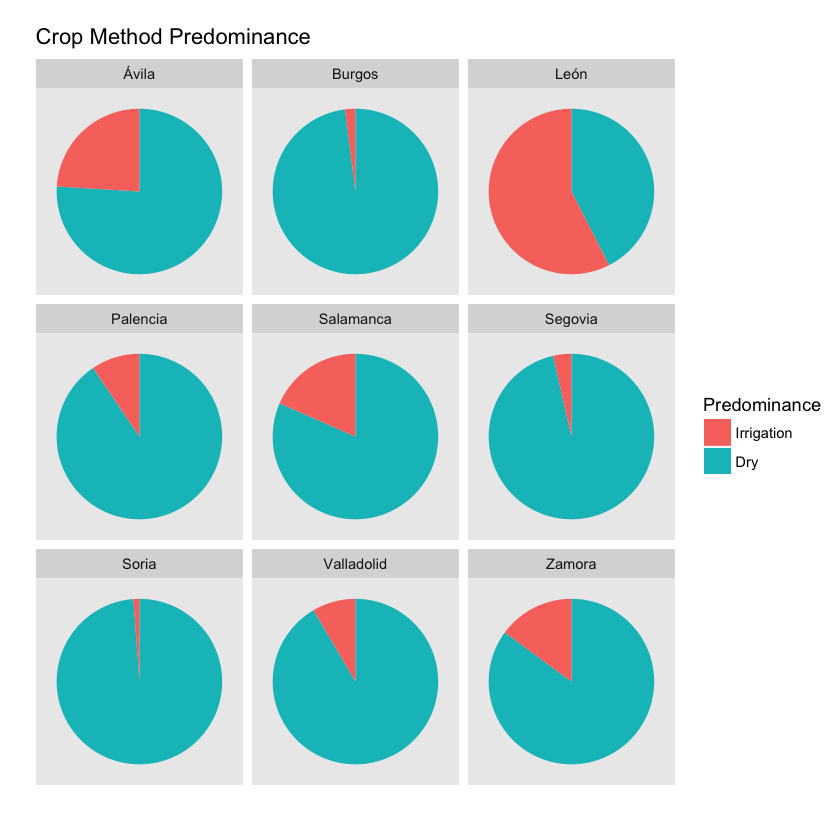

In [14]:
crops.herbaceous.use %>%
    select(town, area.irrigation, area.dry, province) %>%
    group_by(town, province) %>%
    summarise(area.irrigation.total = sum(area.irrigation, na.rm = TRUE),
              area.dry.total = sum(area.dry, na.rm = TRUE)) %>%
    group_by(province) %>%
    summarise(Irrigation = sum(area.irrigation.total > area.dry.total, na.rm = TRUE),
              Dry = sum(area.irrigation.total < area.dry.total, na.rm = TRUE)) %>%
    mutate(total = Irrigation + Dry,
          Irrigation = Irrigation / total,
          Dry = Dry / total) %>%
    select(-total) %>%
    melt(id.vars = "province") %>%
    ggplot(aes(x = "", y = value, fill = variable)) +
        geom_bar(stat = "identity", width = 1) +
        labs(title = "Crop Method Predominance", 
             x = "", y = "", fill = "Predominance") +
        coord_polar(theta = "y") + 
        facet_wrap(~province) +
    theme(axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid  = element_blank())

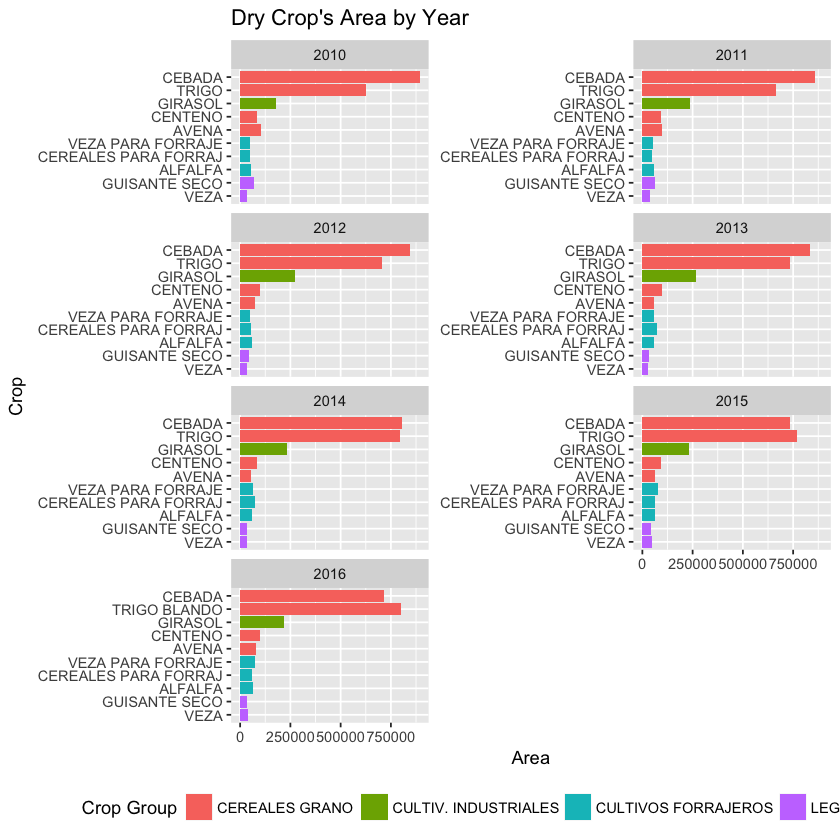

In [15]:
crops.herbaceous.use %>%
  select(crop, year, crop.group, area.dry) %>%
  filter(area.dry > 0) %>%
  group_by(crop.group, year, crop) %>%
  summarise(ocupacion = sum(area.dry, na.rm = TRUE)) %>%
  ungroup() %>%
  group_by(year) %>%
  top_n(10, ocupacion) %>%
  ggplot(aes(x = reorder(crop, ocupacion), y = ocupacion)) + 
    geom_bar(aes(fill = crop.group), stat = "identity") + 
    theme(legend.position='bottom') + 
    labs(title = "Dry Crop's Area by Year", 
         x = "Crop", y = "Area", fill = "Crop Group") +
    coord_flip() + 
    facet_wrap(~year, scales = "free_y", ncol = 2)

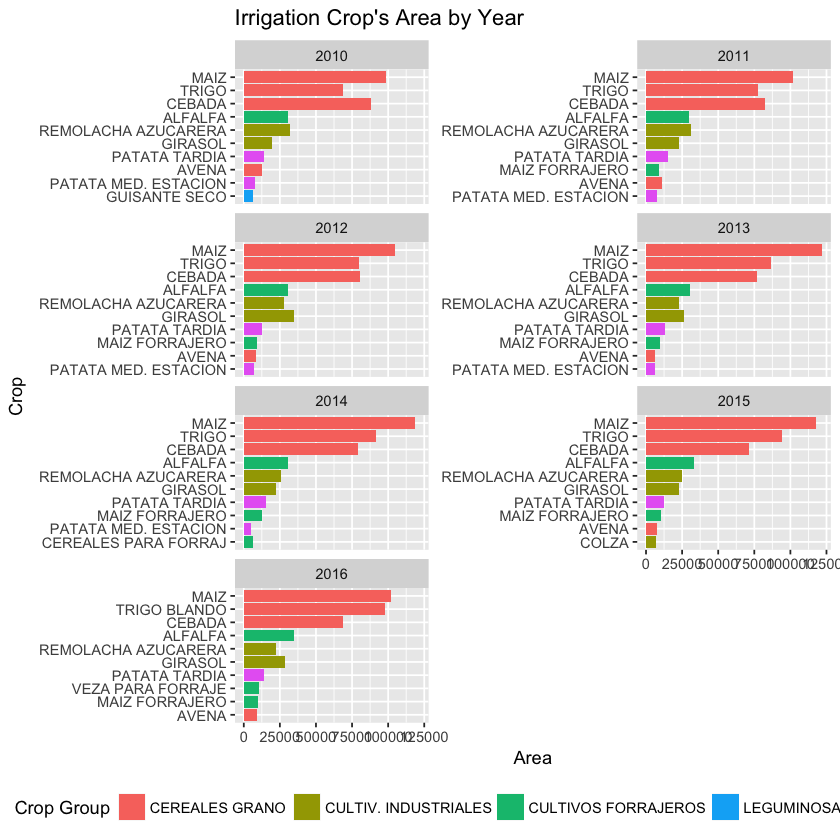

In [16]:
crops.herbaceous.use %>%
  select(crop, crop.group, year, area.irrigation) %>%
  group_by(crop.group, year, crop) %>%
  summarise(ocupacion = sum(area.irrigation, na.rm = TRUE)) %>%
  ungroup() %>%
  group_by(year) %>%
  top_n(10, ocupacion) %>%
  ggplot(aes(x = reorder(crop, ocupacion), y = ocupacion)) + 
    geom_bar(aes(fill = crop.group), stat = "identity") + 
    theme(legend.position='bottom') + 
    labs(title = "Irrigation Crop's Area by Year", 
         x = "Crop", y = "Area", fill = "Crop Group") +
    coord_flip() + 
    facet_wrap(~year, scales = "free_y", ncol = 2)

### Correspondence Analysis

In [17]:
crops.herbaceous.use.ca.dry <- crops.herbaceous.use %>%
    select(crop.group, province, area.dry) %>%
    filter(area.dry > 0) %>%
    xtabs(formula = area.dry ~ .) %>%
    ca()

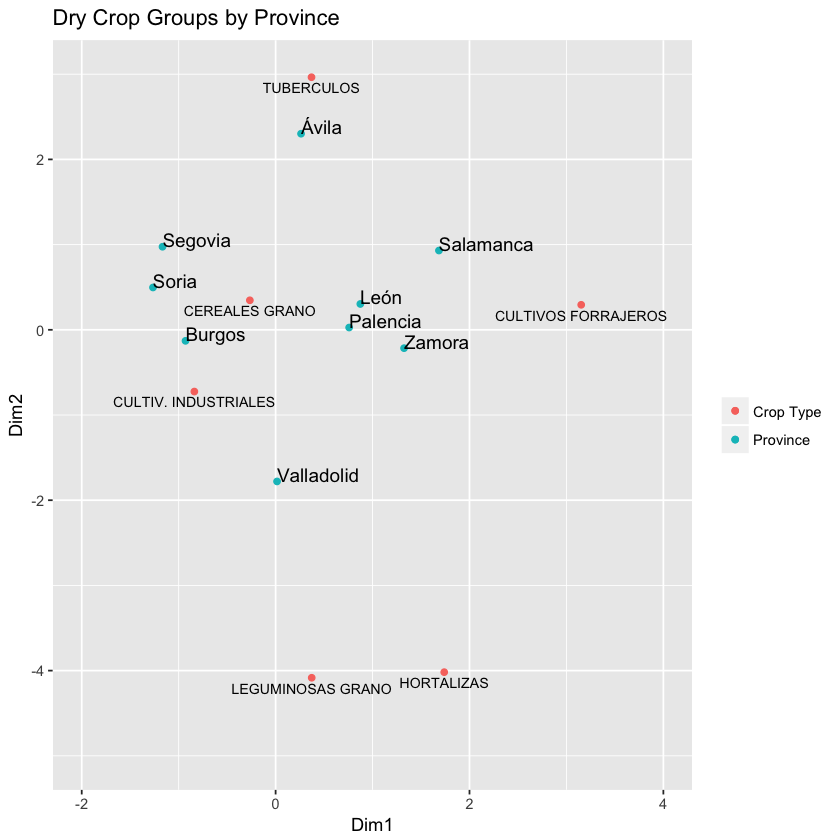

In [18]:
ggplot(mapping = aes(x =Dim1, y = Dim2 )) +
    labs(title = "Dry Crop Groups by Province", 
         colour = "") +
    geom_point(data = as.data.frame(crops.herbaceous.use.ca.dry$colcoord), 
               mapping = aes(colour = 'Province')) + 
    geom_point(data = as.data.frame(crops.herbaceous.use.ca.dry$rowcoord), 
               mapping = aes(colour = 'Crop Type')) + 
    geom_text(data = as.data.frame(crops.herbaceous.use.ca.dry$rowcoord),
              label=rownames(crops.herbaceous.use.ca.dry$rowcoord), 
              hjust=0.5, vjust=1.5, size = 3) +
    geom_text(data = as.data.frame(crops.herbaceous.use.ca.dry$colcoord),
              label=rownames(crops.herbaceous.use.ca.dry$colcoord), 
              hjust=0, vjust=0, size = 4) +
    coord_cartesian(xlim = c(-2, 4), ylim = c(-5, 3)) 


In [19]:
crops.herbaceous.use.ca.irrigation <- crops.herbaceous.use %>%
    select(crop.group, province, area.irrigation) %>%
    filter(area.irrigation > 0) %>%
    xtabs(formula = area.irrigation ~ .) %>%
    ca()

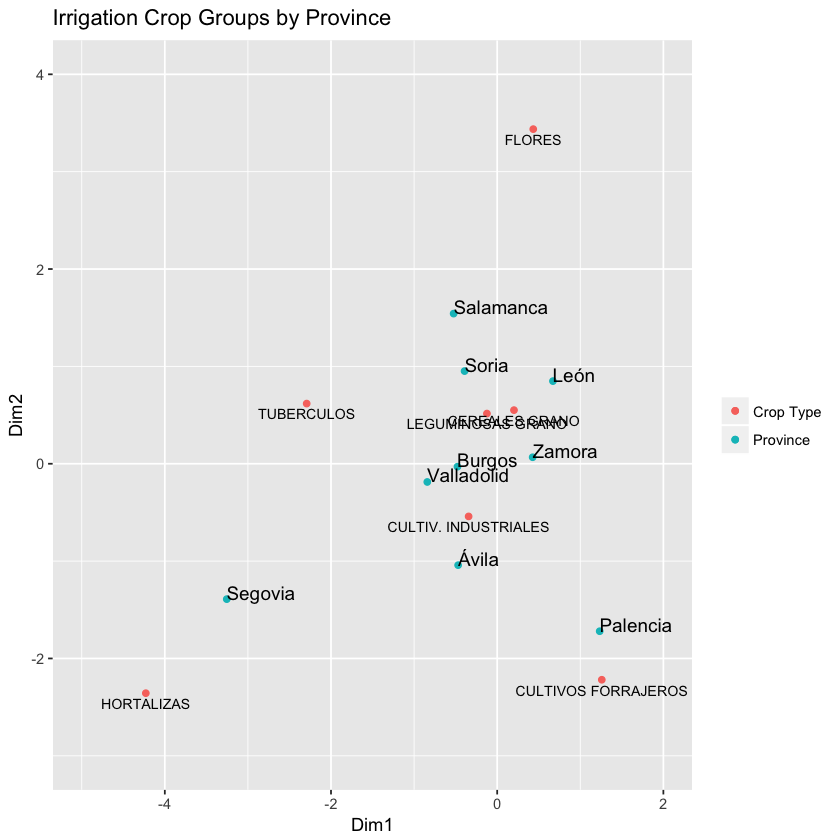

In [20]:
ggplot(mapping = aes(x =Dim1, y = Dim2 )) +
    labs(title = "Irrigation Crop Groups by Province", 
         colour = "") +
    geom_point(data = as.data.frame(crops.herbaceous.use.ca.irrigation$colcoord), 
               mapping = aes(colour = 'Province')) + 
    geom_point(data = as.data.frame(crops.herbaceous.use.ca.irrigation$rowcoord), 
               mapping = aes(colour = 'Crop Type')) + 
    geom_text(data = as.data.frame(crops.herbaceous.use.ca.irrigation$rowcoord),
              label=rownames(crops.herbaceous.use.ca.irrigation$rowcoord), 
              hjust=0.5, vjust=1.5, size = 3) +
    geom_text(data = as.data.frame(crops.herbaceous.use.ca.irrigation$colcoord),
              label=rownames(crops.herbaceous.use.ca.irrigation$colcoord), 
              hjust=0, vjust=0, size = 4) +
    coord_cartesian(xlim = c(-5, 2), ylim = c(-3, 4)) 